# Text Mining & Search
Authors
- Alexandre Crivellari
- Andrea Muscio

# Introduction

[TO DO]

# Workspace setting

## Dependencies

In [11]:
#%pip install pandas numpy matplotlib seaborn scikit-learn
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

## Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset upload and exploration

In [2]:
# Define the column names
columns = ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 
           'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 
           'mostly_true_counts', 'pants_on_fire_counts', 'context']

# Read the TSV files
train_df = pd.read_csv('train.tsv', sep='\t', names=columns)
valid_df = pd.read_csv('valid.tsv', sep='\t', names=columns)
test_df = pd.read_csv('test.tsv', sep='\t', names=columns)

# Display the first few rows of the training data
train_df.head()

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [3]:
print(train_df.columns)

Index(['id', 'label', 'statement', 'subject', 'speaker', 'job_title',
       'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts',
       'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts',
       'context'],
      dtype='object')


id                      0
label                   0
statement               0
subject                 0
speaker                 0
job_title               0
state_info              0
party_affiliation       0
barely_true_counts      0
false_counts            0
half_true_counts        0
mostly_true_counts      0
pants_on_fire_counts    0
context                 0
label_encoded           0
statement_length        0
total_statements        0
dtype: int64
label
half-true      0.206445
false          0.194824
mostly-true    0.191602
true           0.163672
barely-true    0.161523
pants-fire     0.081934
Name: proportion, dtype: float64


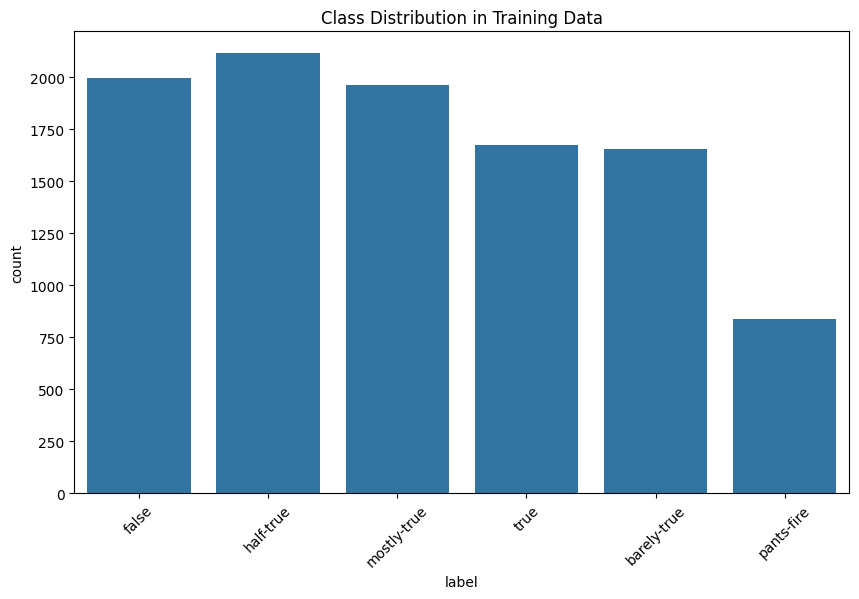

In [9]:
# Check for missing values
print(train_df.isnull().sum())

# Handle missing values (if any)
train_df = train_df.fillna('unknown')
valid_df = valid_df.fillna('unknown')
test_df = test_df.fillna('unknown')

# Handle missing values
categorical_columns = ['subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'context']
numeric_columns = ['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']

# For categorical columns, fill with 'Unknown' instead of 'unknown'
for col in categorical_columns:
    train_df[col] = train_df[col].fillna('Unknown')
    valid_df[col] = valid_df[col].fillna('Unknown')
    test_df[col] = test_df[col].fillna('Unknown')

# For numeric columns, ensure they are numeric and fill with median
for col in numeric_columns:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
    valid_df[col] = pd.to_numeric(valid_df[col], errors='coerce')
    test_df[col] = pd.to_numeric(test_df[col], errors='coerce')
    
    median_value = train_df[col].median()
    train_df[col] = train_df[col].fillna(median_value)
    valid_df[col] = valid_df[col].fillna(median_value)
    test_df[col] = test_df[col].fillna(median_value)

# Encode labels
le = LabelEncoder()
train_df['label_encoded'] = le.fit_transform(train_df['label'])
valid_df['label_encoded'] = le.transform(valid_df['label'])
test_df['label_encoded'] = le.transform(test_df['label'])

# Display class distribution
print(train_df['label'].value_counts(normalize=True))

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_df)
plt.title('Class Distribution in Training Data')
plt.xticks(rotation=45)
plt.show()

## Feature Engineering

In [10]:
# Step 2: Feature Engineering (updated)

# Create a feature for statement length
train_df['statement_length'] = train_df['statement'].str.len()
valid_df['statement_length'] = valid_df['statement'].str.len()
test_df['statement_length'] = test_df['statement'].str.len()

# Aggregate count features
count_columns = ['barely_true_counts', 'false_counts', 'half_true_counts', 
                 'mostly_true_counts', 'pants_on_fire_counts']

train_df['total_statements'] = train_df[count_columns].sum(axis=1)
valid_df['total_statements'] = valid_df[count_columns].sum(axis=1)
test_df['total_statements'] = test_df[count_columns].sum(axis=1)

# (Task 1) Text Classification

Single-Label Multi-Class

## Model Selection and Training

[Descrizione di cosa faremo]

### Traditional ML Model (Random Forest)

[Descrizione del modello]

Random Forest Performance:
              precision    recall  f1-score   support

        true       0.47      0.28      0.35       237
 mostly-true       0.44      0.60      0.51       263
   half-true       0.40      0.53      0.45       248
 barely-true       0.42      0.54      0.47       251
       false       0.76      0.38      0.51       116
  pants-fire       0.65      0.25      0.36       169

    accuracy                           0.45      1284
   macro avg       0.52      0.43      0.44      1284
weighted avg       0.49      0.45      0.44      1284



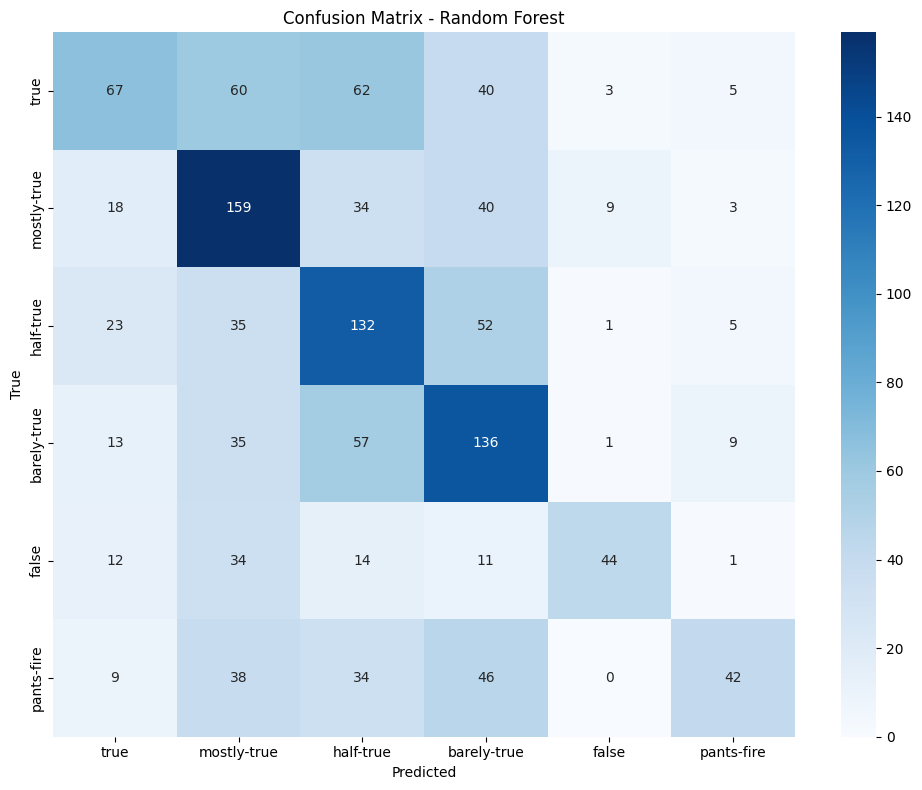

In [16]:
# Prepare features for Random Forest
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(train_df['statement'])
X_valid_tfidf = tfidf.transform(valid_df['statement'])

# Select only numeric features
numeric_features = ['statement_length', 'total_statements'] + count_columns

# Combine TF-IDF features with numeric features
X_train = np.hstack((X_train_tfidf.toarray(), train_df[numeric_features]))
X_valid = np.hstack((X_valid_tfidf.toarray(), valid_df[numeric_features]))

y_train = train_df['label_encoded']
y_valid = valid_df['label_encoded']

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on validation set
y_pred_rf = rf_model.predict(X_valid)

# Define the correct order of labels
correct_order = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire']

# Ensure the LabelEncoder uses this order
le_ordered = LabelEncoder()
le_ordered.fit(correct_order)

# Map the predictions and true labels to the correct order
y_valid_ordered = le_ordered.transform(le.inverse_transform(y_valid))
y_pred_rf_ordered = le_ordered.transform(le.inverse_transform(y_pred_rf))

# Evaluate the model
print("Random Forest Performance:")
print(classification_report(y_valid_ordered, y_pred_rf_ordered, target_names=correct_order))

# Plot confusion matrix
cm = confusion_matrix(y_valid_ordered, y_pred_rf_ordered)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=correct_order, yticklabels=correct_order)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [17]:
#Saving the model and preprocessors
import joblib
import os

# Create a directory to save the model if it doesn't exist
os.makedirs('saved_model', exist_ok=True)

# Save the Random Forest model
rf_model_save_path = 'saved_model/random_forest_fake_news_classifier.joblib'
joblib.dump(rf_model, rf_model_save_path)

# Save the TF-IDF vectorizer
tfidf_save_path = 'saved_model/tfidf_vectorizer.joblib'
joblib.dump(tfidf, tfidf_save_path)

# Save the LabelEncoder
le_save_path = 'saved_model/label_encoder.joblib'
joblib.dump(le, le_save_path)

# Save the list of numeric features
numeric_features_save_path = 'saved_model/numeric_features.joblib'
joblib.dump(numeric_features, numeric_features_save_path)

print(f"Random Forest model saved to {rf_model_save_path}")
print(f"TF-IDF vectorizer saved to {tfidf_save_path}")
print(f"LabelEncoder saved to {le_save_path}")
print(f"Numeric features list saved to {numeric_features_save_path}")

# To load the model and preprocessors later:
# loaded_rf_model = joblib.load(rf_model_save_path)
# loaded_tfidf = joblib.load(tfidf_save_path)
# loaded_le = joblib.load(le_save_path)
# loaded_numeric_features = joblib.load(numeric_features_save_path)

Random Forest model saved to saved_model/random_forest_fake_news_classifier.joblib
TF-IDF vectorizer saved to saved_model/tfidf_vectorizer.joblib
LabelEncoder saved to saved_model/label_encoder.joblib
Numeric features list saved to saved_model/numeric_features.joblib


### Deep Learning Model (BERT)

[Scrivere qua]

In [13]:
# Prepare data for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def prepare_bert_input(df):
    encoded_data = tokenizer.batch_encode_plus(
        df['statement'].tolist(),
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=128,
        return_tensors='pt'
    )
    input_ids = encoded_data['input_ids']
    attention_masks = encoded_data['attention_mask']
    labels = torch.tensor(df['label_encoded'].tolist())
    return input_ids, attention_masks, labels

train_inputs, train_masks, train_labels = prepare_bert_input(train_df)
valid_inputs, valid_masks, valid_labels = prepare_bert_input(valid_df)

# Create DataLoaders
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = torch.utils.data.RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

valid_data = TensorDataset(valid_inputs, valid_masks, valid_labels)
valid_sampler = torch.utils.data.SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=32)

# Initialize BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))
model.cuda()  # Move model to GPU

# Set up optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Training loop
epochs = 4

for epoch in range(epochs):
    model.train()
    for batch in train_dataloader:
        batch = tuple(t.to('cuda') for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        optimizer.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    val_accuracy = []
    for batch in valid_dataloader:
        batch = tuple(t.to('cuda') for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        accuracy = (predictions == b_labels).float().mean()
        val_accuracy.append(accuracy.item())
    
    print(f"Epoch {epoch+1} - Validation Accuracy: {np.mean(val_accuracy):.4f}")

c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\transformers\tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=T

Epoch 1 - Validation Accuracy: 0.2584
Epoch 2 - Validation Accuracy: 0.2622
Epoch 3 - Validation Accuracy: 0.2492
Epoch 4 - Validation Accuracy: 0.2622


NameError: name 'b_' is not defined

### Model BERT evaluation

BERT Model Performance:
              precision    recall  f1-score   support

        true       0.24      0.26      0.25       237
 mostly-true       0.27      0.32      0.30       263
   half-true       0.24      0.33      0.28       248
 barely-true       0.28      0.21      0.24       251
       false       0.44      0.23      0.30       116
  pants-fire       0.29      0.21      0.25       169

    accuracy                           0.27      1284
   macro avg       0.29      0.26      0.27      1284
weighted avg       0.28      0.27      0.27      1284



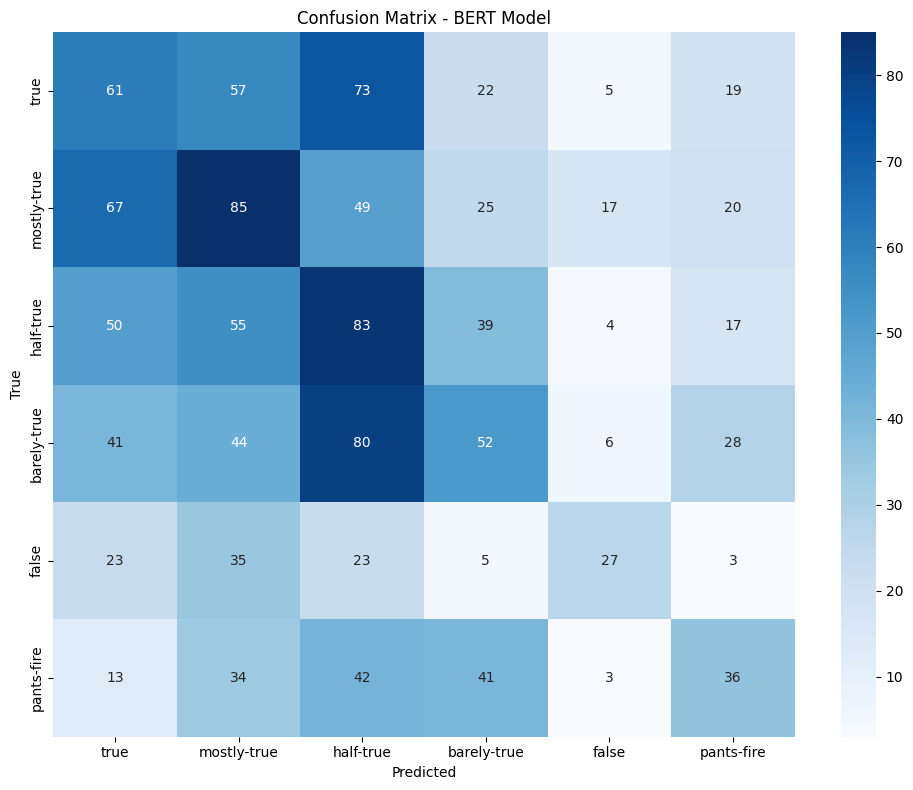

In [15]:
# Evaluate BERT model
model.eval()
bert_predictions = []
true_labels = []

with torch.no_grad():
    for batch in valid_dataloader:
        batch = tuple(t.to('cuda') for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)
        
        bert_predictions.extend(predictions.cpu().numpy())
        true_labels.extend(b_labels.cpu().numpy())

# Convert predictions and true labels back to original label names
bert_predictions = le.inverse_transform(bert_predictions)
true_labels = le.inverse_transform(true_labels)

# Ensure the correct order of labels
correct_order = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire']
le_ordered = LabelEncoder()
le_ordered.fit(correct_order)

bert_predictions_ordered = le_ordered.transform(bert_predictions)
true_labels_ordered = le_ordered.transform(true_labels)

# Print classification report
print("BERT Model Performance:")
print(classification_report(true_labels_ordered, bert_predictions_ordered, target_names=correct_order))

# Plot confusion matrix
cm = confusion_matrix(true_labels_ordered, bert_predictions_ordered)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=correct_order, yticklabels=correct_order)
plt.title('Confusion Matrix - BERT Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [14]:
import os
import torch
from transformers import BertForSequenceClassification

# Assuming your model is called 'model' and is already trained

# Create a directory to save the model
os.makedirs('saved_model', exist_ok=True)

# Save the model
model_save_path = 'saved_model/bert_fake_news_classifier.pt'
torch.save(model.state_dict(), model_save_path)

# Save the configuration
model.config.save_pretrained('saved_model')

print(f"Model saved to {model_save_path}")


Model saved to saved_model/bert_fake_news_classifier.pt


### DL ROBERTA

In [20]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import os

# Set up GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [21]:
# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def prepare_roberta_input(df, tokenizer, max_length=128):
    encoded_data = tokenizer.batch_encode_plus(
        df['statement'].tolist(),
        add_special_tokens=True,
        return_attention_mask=True,
        padding='max_length',
        max_length=max_length,
        truncation=True,
        return_tensors='pt'
    )
    input_ids = encoded_data['input_ids']
    attention_masks = encoded_data['attention_mask']
    labels = torch.tensor(df['label_encoded'].tolist())
    return input_ids, attention_masks, labels

# Prepare data
train_inputs, train_masks, train_labels = prepare_roberta_input(train_df, tokenizer)
valid_inputs, valid_masks, valid_labels = prepare_roberta_input(valid_df, tokenizer)

# Create DataLoaders
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

valid_data = TensorDataset(valid_inputs, valid_masks, valid_labels)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)


c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
